In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class VariationalDense(nn.Module):
    def __init__(self, n_in, n_out, model_prob, model_lam):
        super(VariationalDense, self).__init__()
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_M = nn.Parameter(torch.randn(n_in, n_out) * 0.01)
        self.model_m = nn.Parameter(torch.zeros(n_out))

    def forward(self, x, activation=lambda x: x):
        # Sample Bernoulli variables
        bernoulli_dist = torch.distributions.Bernoulli(probs=self.model_prob)
        bern_samples = bernoulli_dist.sample((self.model_M.size(0),)).to(self.model_M.device)
        # Create model_W by masking model_M
        bern_samples = bern_samples[:, None]  # Shape (n_in, 1)
        model_W = bern_samples * self.model_M  # Element-wise multiplication
        output = activation(x @ model_W + self.model_m)
        if model_W.size(1) == 1:
            output = output.squeeze()
        return output

    @property
    def regularization(self):
        return self.model_lam * (
            self.model_prob * torch.sum(self.model_M ** 2) +
            torch.sum(self.model_m ** 2)
        )

# Create sample data
n_samples = 20
X_np = np.random.normal(size=(n_samples, 1))
y_np = np.random.normal(np.cos(5.*X_np) / (np.abs(X_np) + 1.), 0.1).ravel()
X_pred_np = np.atleast_2d(np.linspace(-3., 3., num=100)).T
X_np = np.hstack((X_np, X_np**2, X_np**3))
X_pred_np = np.hstack((X_pred_np, X_pred_np**2, X_pred_np**3))

# Convert data to PyTorch tensors
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()
X_pred = torch.from_numpy(X_pred_np).float()

# Create the PyTorch model
n_feats = X.shape[1]
n_hidden = 100
model_prob = 0.9
model_lam = 1e-2

model_L1 = VariationalDense(n_feats, n_hidden, model_prob, model_lam)
model_L2 = VariationalDense(n_hidden, n_hidden, model_prob, model_lam)
model_L3 = VariationalDense(n_hidden, 1, model_prob, model_lam)

# Set up the optimizer
optimizer = optim.Adam(
    list(model_L1.parameters()) + 
    list(model_L2.parameters()) + 
    list(model_L3.parameters()), 
    lr=1e-3
)

# Training loop
n_epochs = 10000
n_samples = X.size(0)
for i in range(n_epochs):
    optimizer.zero_grad()
    model_out_1 = model_L1(X, activation=nn.ReLU())
    model_out_2 = model_L2(model_out_1, activation=nn.ReLU())
    model_pred = model_L3(model_out_2)
    model_pred = model_pred.squeeze()
    model_sse = torch.sum((y - model_pred) ** 2)
    model_mse = model_sse / n_samples
    model_loss = (
        model_sse +
        model_L1.regularization +
        model_L2.regularization +
        model_L3.regularization
    ) / n_samples
    model_loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print("Iteration {}. Mean squared error: {:.4f}.".format(i, model_mse.item()))

# Sample from the posterior
n_post = 1000
Y_post = np.zeros((n_post, X_pred.shape[0]))
with torch.no_grad():
    for i in range(n_post):
        model_out_1 = model_L1(X_pred, activation=nn.ReLU())
        model_out_2 = model_L2(model_out_1, activation=nn.ReLU())
        model_pred_post = model_L3(model_out_2)
        Y_post[i] = model_pred_post.squeeze().cpu().numpy()

Iteration 0. Mean squared error: 0.2540.
Iteration 100. Mean squared error: 0.1954.
Iteration 200. Mean squared error: 0.2081.
Iteration 300. Mean squared error: 0.0316.
Iteration 400. Mean squared error: 0.0322.
Iteration 500. Mean squared error: 0.0140.
Iteration 600. Mean squared error: 0.0112.
Iteration 700. Mean squared error: 0.0156.
Iteration 800. Mean squared error: 0.0093.
Iteration 900. Mean squared error: 0.0652.
Iteration 1000. Mean squared error: 0.0093.
Iteration 1100. Mean squared error: 0.0289.
Iteration 1200. Mean squared error: 0.0123.
Iteration 1300. Mean squared error: 0.0393.
Iteration 1400. Mean squared error: 0.0506.
Iteration 1500. Mean squared error: 0.0099.
Iteration 1600. Mean squared error: 0.0067.
Iteration 1700. Mean squared error: 0.0543.
Iteration 1800. Mean squared error: 0.0539.
Iteration 1900. Mean squared error: 0.0358.
Iteration 2000. Mean squared error: 0.0445.
Iteration 2100. Mean squared error: 0.0217.
Iteration 2200. Mean squared error: 0.0093.


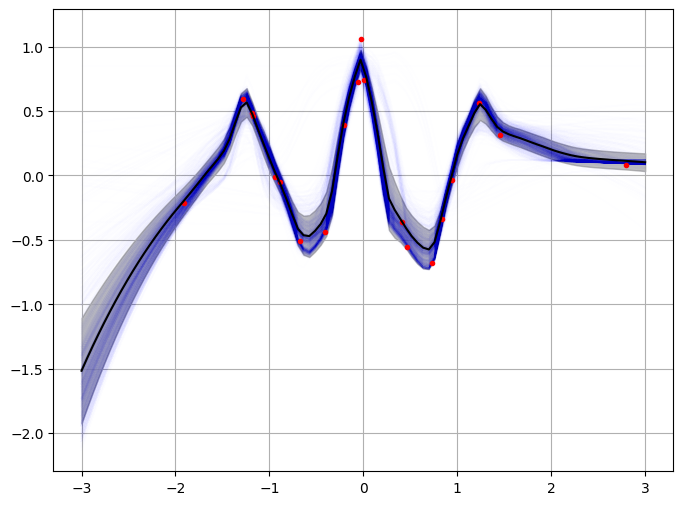

In [10]:


# Calculate the standard deviation for each value of x in Y_post
Y_post_std = np.std(Y_post, axis=0)
Y_post_mean = np.mean(Y_post, axis=0)
# Plot the results
plt.figure(figsize=(8, 6))
for i in range(n_post):
    plt.plot(X_pred_np[:, 0], Y_post[i], "b-", alpha=1. / 200)
plt.plot(X_np[:, 0], y_np, "r.")
plt.plot(X_pred_np[:, 0], Y_post_mean, "k-")
plt.fill_between(X_pred_np[:, 0], Y_post_mean - Y_post_std, Y_post_mean + Y_post_std, color='gray', alpha=0.5)
plt.grid()
plt.show()